# 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from konlpy.tag import Mecab

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터 로더 구성

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [3]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
print(index_to_word[1])     # 'the' 가 출력됩니다. 
#print(word_to_index['the'])  # 1 이 출력됩니다.

<BOS>


In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


# 모델 구성을 위한 데이터 분석 및 가공   
## max값 확인하기

In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


# pre로 paddig 하기 

In [9]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


# 1-D CNN 모델 설계

In [10]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

# 1-D CNN validation set 설정

In [11]:
# validation set 30000건 분리
x_val = x_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 116182건
partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


# 1-D CNN 모델 학습 및 테스트셋으로 평가

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
227/227 [==============================] - 6s 26ms/step - loss: 0.4951 - accuracy: 0.7473 - val_loss: 0.3568 - val_accuracy: 0.8450
Epoch 2/15
227/227 [==============================] - 1s 6ms/step - loss: 0.3318 - accuracy: 0.8594 - val_loss: 0.3425 - val_accuracy: 0.8522
Epoch 3/15
227/227 [==============================] - 1s 6ms/step - loss: 0.3000 - accuracy: 0.8745 - val_loss: 0.3392 - val_accuracy: 0.8531
Epoch 4/15
227/227 [==============================] - 1s 6ms/step - loss: 0.2748 - accuracy: 0.8875 - val_loss: 0.3408 - val_accuracy: 0.8534
Epoch 5/15
227/227 [==============================] - 1s 6ms/step - loss: 0.2462 - accuracy: 0.9024 - val_loss: 0.3509 - val_accuracy: 0.8517
Epoch 6/15
227/227 [==============================] - 1s 6ms/step - loss: 0.2144 - accuracy: 0.9173 - val_loss: 0.3718 - val_accuracy: 0.8489
Epoch 7/15
227/227 [==============================] - 1s 6ms/step - loss: 0.1820 - accuracy: 0.9330 - val_loss: 0.4117 - val_accuracy: 0.8443
Epoch

In [13]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7879 - accuracy: 0.8204
[0.7878895998001099, 0.8203511238098145]


# GlobalMaxPooling1D() 모델 설계
words 리스트를 이쓴데 어케만드냐면 불용 다 제거 후 토큰화하고 리스트에 어펜드하면 순소가 생기는데 빈도가 높은거부터 순서가 생김 앞에를 자름

In [14]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


# GlobalMaxPooling1D() validation set 설정

In [15]:
# validation set 30000건 분리
x_val = x_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 116182건
partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)


(116182, 41)
(116182,)


# GlobalMaxPooling1D() 모델 학습 및 테스트셋으로 평가

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
227/227 [==============================] - 1s 4ms/step - loss: 0.6280 - accuracy: 0.7079 - val_loss: 0.5176 - val_accuracy: 0.7853
Epoch 2/15
227/227 [==============================] - 1s 3ms/step - loss: 0.4440 - accuracy: 0.8100 - val_loss: 0.4055 - val_accuracy: 0.8191
Epoch 3/15
227/227 [==============================] - 1s 3ms/step - loss: 0.3788 - accuracy: 0.8370 - val_loss: 0.3834 - val_accuracy: 0.8294
Epoch 4/15
227/227 [==============================] - 1s 3ms/step - loss: 0.3520 - accuracy: 0.8499 - val_loss: 0.3768 - val_accuracy: 0.8317
Epoch 5/15
227/227 [==============================] - 1s 3ms/step - loss: 0.3347 - accuracy: 0.8570 - val_loss: 0.3757 - val_accuracy: 0.8324
Epoch 6/15
227/227 [==============================] - 1s 4ms/step - loss: 0.3222 - accuracy: 0.8634 - val_loss: 0.3777 - val_accuracy: 0.8340
Epoch 7/15
227/227 [==============================] - 1s 3ms/step - loss: 0.3126 - accuracy: 0.8682 - val_loss: 0.3807 - val_accuracy: 0.8347
Epoch 

In [17]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4182 - accuracy: 0.8244
[0.4181608259677887, 0.824440062046051]


# RNN 모델 설계

In [18]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________


# RNN validation set 설정

In [19]:
# validation set 30000건 분리
x_val = x_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 116182건
partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)


(116182, 41)
(116182,)


# RNN 모델 학습 및 테스트셋으로 평가

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
227/227 [==============================] - 2s 8ms/step - loss: 0.4992 - accuracy: 0.7591 - val_loss: 0.3634 - val_accuracy: 0.8435
Epoch 2/15
227/227 [==============================] - 2s 7ms/step - loss: 0.3435 - accuracy: 0.8538 - val_loss: 0.3455 - val_accuracy: 0.8517
Epoch 3/15
227/227 [==============================] - 2s 7ms/step - loss: 0.3194 - accuracy: 0.8668 - val_loss: 0.3457 - val_accuracy: 0.8523
Epoch 4/15
227/227 [==============================] - 1s 7ms/step - loss: 0.3089 - accuracy: 0.8718 - val_loss: 0.3468 - val_accuracy: 0.8515
Epoch 5/15
227/227 [==============================] - 1s 7ms/step - loss: 0.2982 - accuracy: 0.8768 - val_loss: 0.3526 - val_accuracy: 0.8485
Epoch 6/15
227/227 [==============================] - 2s 7ms/step - loss: 0.2885 - accuracy: 0.8812 - val_loss: 0.3514 - val_accuracy: 0.8486
Epoch 7/15
227/227 [==============================] - 2s 7ms/step - loss: 0.2786 - accuracy: 0.8859 - val_loss: 0.3585 - val_accuracy: 0.8500
Epoch 

In [21]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4254 - accuracy: 0.8383
[0.42539116740226746, 0.838334321975708]


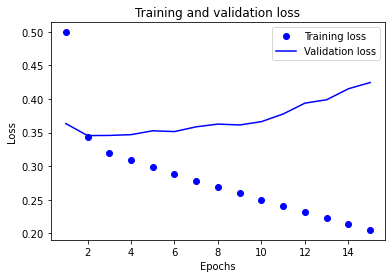

In [22]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

---
CNN accuracy: 0.8229, RNN :accuracy: 0.8385, Maxpooling accuracy: 0.8234 로 CNN이 제일 낮게, RNN이 제일 높게 나왔다. 정확도가 높은 RNN을 그래프화하여 확인하고, 제일 낮은 모델과 높은 모델에 Word2Vec(워드벡터)을 적용해 보았다. 

# RNN LOSS, Accuracy 그래프 시각화

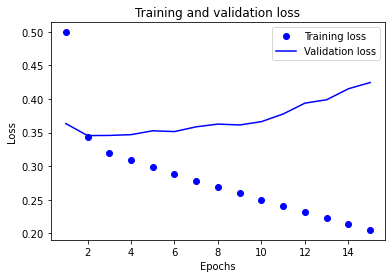

In [23]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

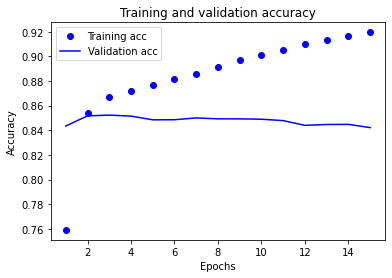

In [24]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Word2Vec 설계

In [25]:
from gensim.models import KeyedVectors
import os
import gensim

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko_model = gensim.models.Word2Vec.load('./aiffel/sentiment_classification/ko.bin')
word2vec = ko_model

In [26]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]
        
print("ok")

ok


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


# CNN + Word2Vec 

In [27]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [28]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 12s 54ms/step - loss: 0.5630 - accuracy: 0.6924 - val_loss: 0.4459 - val_accuracy: 0.7957
Epoch 2/20
227/227 [==============================] - 9s 39ms/step - loss: 0.4002 - accuracy: 0.8212 - val_loss: 0.3838 - val_accuracy: 0.8298
Epoch 3/20
227/227 [==============================] - 9s 39ms/step - loss: 0.3364 - accuracy: 0.8554 - val_loss: 0.3609 - val_accuracy: 0.8427
Epoch 4/20
227/227 [==============================] - 9s 40ms/step - loss: 0.2996 - accuracy: 0.8758 - val_loss: 0.3531 - val_accuracy: 0.8465
Epoch 5/20
227/227 [==============================] - 9s 40ms/step - loss: 0.2712 - accuracy: 0.8894 - val_loss: 0.3636 - val_accuracy: 0.8461
Epoch 6/20
227/227 [==============================] - 9s 39ms/step - loss: 0.2482 - accuracy: 0.9010 - val_loss: 0.3653 - val_accuracy: 0.8465
Epoch 7/20
227/227 [==============================] - 9s 41ms/step - loss: 0.2233 - accuracy: 0.9137 - val_loss: 0.3832 - val_accuracy: 0.844

In [29]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.8483 - accuracy: 0.8267
[0.8482732772827148, 0.8266777992248535]


# RNN + Word2Vec

In [30]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,068,369
Trainable params: 2,068,369
Non-trainable params: 0
_________________________________________________________________


In [31]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 11s 47ms/step - loss: 0.4686 - accuracy: 0.7700 - val_loss: 0.3772 - val_accuracy: 0.8337
Epoch 2/10
227/227 [==============================] - 10s 45ms/step - loss: 0.3369 - accuracy: 0.8539 - val_loss: 0.3334 - val_accuracy: 0.8530
Epoch 3/10
227/227 [==============================] - 11s 47ms/step - loss: 0.2934 - accuracy: 0.8771 - val_loss: 0.3262 - val_accuracy: 0.8602
Epoch 4/10
227/227 [==============================] - 10s 45ms/step - loss: 0.2658 - accuracy: 0.8908 - val_loss: 0.3227 - val_accuracy: 0.8606
Epoch 5/10
227/227 [==============================] - 10s 45ms/step - loss: 0.2428 - accuracy: 0.9013 - val_loss: 0.3278 - val_accuracy: 0.8607
Epoch 6/10
227/227 [==============================] - 10s 44ms/step - loss: 0.2207 - accuracy: 0.9119 - val_loss: 0.3386 - val_accuracy: 0.8616
Epoch 7/10
227/227 [==============================] - 10s 45ms/step - loss: 0.1993 - accuracy: 0.9216 - val_loss: 0.3441 - val_accuracy:

In [32]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4349 - accuracy: 0.8511
[0.4349210858345032, 0.8510690331459045]


# LOSS, Accuracy 그래프 시각화

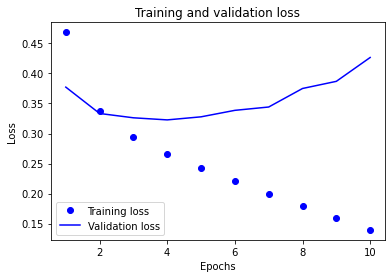

In [33]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

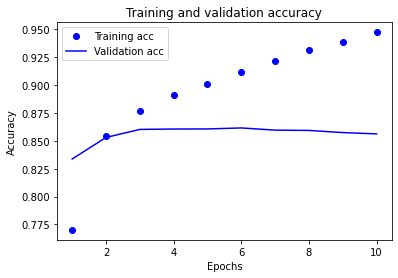

In [34]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 마치며..   
#### CNN accuracy : 0.8229    
#### RNN : accuracy: 0.8385    
#### Maxpooling accuracy: 0.8234   
#### CNN + word2vec accuracy: 0.8267   
#### RNN + word2vec accuracy: 0.8511   
CNN과 RNN 눌다 word2vec을 적용했을 때 정확도가 향상되었고, RNN에 word2vec을 적용 했을 때 85% 이상의 정확도를 달성하였다.